# Exploratory analysis of petTOAD dataframe (CN and MCI patients)

<div class="alert alert-block alert-info">
<b>Remember:</b> For this analysis you need to activate the `analysis` conda environment
</div>

This notebooks serves as a first exploratory analysis of white matter hyperintensities (WMH) volumes in cognitively normal (CN) subjects and patients with mild cognitive impairment (MCI). Data were taken from the Alzheimer's Disease Neuroinitiative (ADNI) database and what we are going to analyze now are the remaining patients after fmriprep/WMH preprocessing. In particular, we have WMH volume data obtained in subject space and transformed from subject space to MNI2009in6cAsym space. Subjects are binned into WMH/no WMH respectively if the have a higher or lower volume of WMH compared to the first quartile of the distribution of WMH volumes in CN subjects, or if they have a summed Fazekas score (periventricular + lobar) less than 2. 

<div class="alert alert-block alert-info">
<b>Note 1:</b> The actual implementation is base on the first quartile of WMH calculated on CN subjects!
</div>

<div class="alert alert-block alert-info">
<b>Note 2:</b> This first parts deals with all subjects available for processing (we may need to get somebody else out in case there are problems with the timeseries extraction)
</div>

In [8]:
# Imports and directories
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
from pathlib import Path

SPINE = Path.cwd().parents[2]
DATA_DIR = SPINE / "data"
UTL_DIR = DATA_DIR / "utils"
RES_DIR = SPINE / "results"

#Read in data
pts_df = pd.read_csv(RES_DIR / "petTOAD_dataframe.csv", index_col = [0])

# Current implementation to say that a patient has WMH is based on the threshold of the subj space WMH volume
pts_df['WMH'] = np.where(pts_df["Group_bin_subj"].str.contains("no_WMH"), "no_WMH", "WMH")

Let's first calculate some general summary statistics.

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MCI v.s. CN: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.483e-04 U_stat=1.338e+04
Median age for CN subjects = 69.0 (IQR = 66.0 - 75.0)
Median age for MCI subjects = 73.0 (IQR = 69.0 - 78.0)


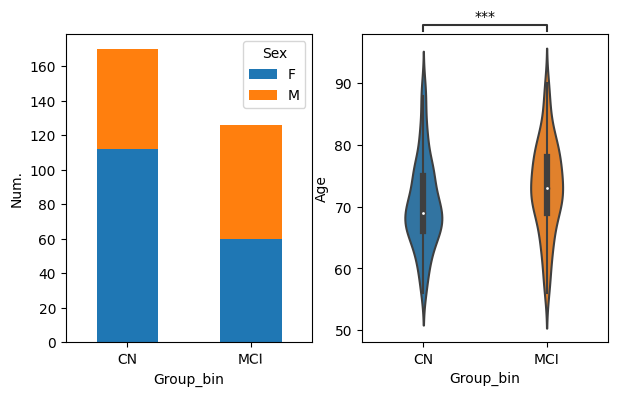

In [2]:
# Create contingency tables
ct_sex = pd.crosstab(pts_df['Sex'], pts_df['Group_bin'])
c1, p1, dof1, expected1 = ss.chi2_contingency(ct_sex)
# Create overall figure
plt.figure(figsize = (7,4))
# Set first graph
axs1 = plt.subplot(1, 2, 1)
ct_sex.T.plot(kind = "bar", stacked = True, rot = 1, ylabel = "Num.", ax = axs1)
# Set second graph
axs2 = plt.subplot(1, 2, 2)
order = ['CN', 'MCI']
vp = sns.violinplot(pts_df, x = "Group_bin", y = "Age", order = order, width = 0.3, ax = axs2)
stats = add_stat_annotation(vp, data=pts_df, x="Group_bin", y="Age",
                    box_pairs=[("CN", "MCI")],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=3);
# Get age summary stats
age_summ = pts_df.groupby(["Group_bin"])['Age'].describe()
print(f"Median age for CN subjects = {age_summ['50%']['CN']} (IQR = {age_summ['25%']['CN']} - {age_summ['75%']['CN']})")
print(f"Median age for MCI subjects = {age_summ['50%']['MCI']} (IQR = {age_summ['25%']['MCI']} - {age_summ['75%']['MCI']})")

In the CN group there are significantly more women than men. MCI patients are significantly older than CN. 

Let's start from data obtained in subject space and let's check out if our data is normally distributed or not. Then, plot the distribution of WMH for CN and MCI patients.

Data is not normally distributed in subject space, you should use non-parametric tests

Data is not normally distributed in MNI space, you should use non-parametric tests

CN v.s. MCI in subject space: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.707e-01 U_stat=9.712e+03

CN v.s. MCI in MNI space: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.493e-01 U_stat=9.660e+03


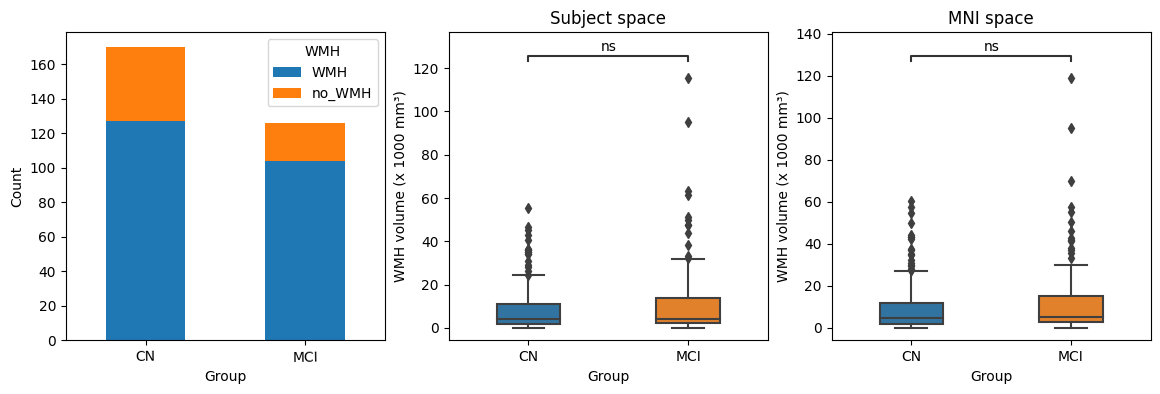

In [3]:
# Create contingency tables for wmh presence
ct_wmh = pd.crosstab(pts_df['WMH'], pts_df['Group_bin'])
c2, p2, dof2, expected2 = ss.chi2_contingency(ct_wmh)

# Test if WMH volumes are normal or not 
normality_subj = ss.normaltest(pts_df["WMH_load_subj_space"])
normality_mni = ss.normaltest(pts_df["WMH_load_subj_space"])
# If normal use parametric tests, else use non-parametric
if normality_subj[1] < 0.05:
    print("Data is not normally distributed in subject space, you should use non-parametric tests\n")
else:
    print("Data is normally distributed in subject space, you should use parametric tests\n")

if normality_mni[1] < 0.05:
    print("Data is not normally distributed in MNI space, you should use non-parametric tests\n")
else:
    print("Data is normally distributed in MNI space, you should use parametric tests\n")

# Create figure
order = ['CN', 'MCI']
plt.figure(figsize = (14,4))
# First part is count of how many patients have/don't have WMH with our cutoff
axs1 = plt.subplot(1, 3, 1)
f1 = ct_wmh.T.plot(kind = "bar", stacked = True, rot = 1, ax = axs1)
plt.xlabel("Group")
plt.ylabel("Count")

# Second part is boxplot of WMH lesion load in subj space
axs2 = plt.subplot(1, 3, 2)
# Divide by 1000 to make it shorter on the graph
wmh_less_zeros = pts_df['WMH_load_subj_space'] / 1000
f2 = sns.boxplot(data=pts_df, x = "Group_bin", y = wmh_less_zeros, order = order, width = 0.4, ax = axs2);
# Add statistical annotation on graph
sa1 = add_stat_annotation(f2, data=pts_df, x="Group_bin", y=wmh_less_zeros, order=order,
                    box_pairs=[("CN", "MCI")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=0);
# Also print the results
print(f"CN v.s. MCI in subject space: {sa1[1][0]}\n")
plt.xlabel("Group")
plt.ylabel("WMH volume (x 1000 mm\u00b3)")
plt.title("Subject space")

# Third part is boxplot of WMH lesion load in MNI space
axs3 = plt.subplot(1, 3, 3)
wmh_less_zeros_mni = pts_df['WMH_load_mni_space'] / 1000
f3 = sns.boxplot(data=pts_df, x = "Group_bin", y = wmh_less_zeros_mni, order = order, width = 0.4, ax = axs3);
# Add statistical annotation on graph
sa2 = add_stat_annotation(f3, data=pts_df, x="Group_bin", y=wmh_less_zeros_mni, order=order,
                    box_pairs=[("CN", "MCI")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=0);
# Also print the results
print(f"CN v.s. MCI in MNI space: {sa2[1][0]}")
plt.xlabel("Group")
plt.ylabel("WMH volume (x 1000 mm\u00b3)")
plt.title("MNI space");

Data is not normally distributed in subject space, you should use non-parametric tests

Data is not normally distributed in MNI space, you should use non-parametric tests

CN v.s. MCI in subject space: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.199e-01 U_stat=1.785e+03

CN v.s. MCI in MNI space: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.693e-01 U_stat=1.769e+03


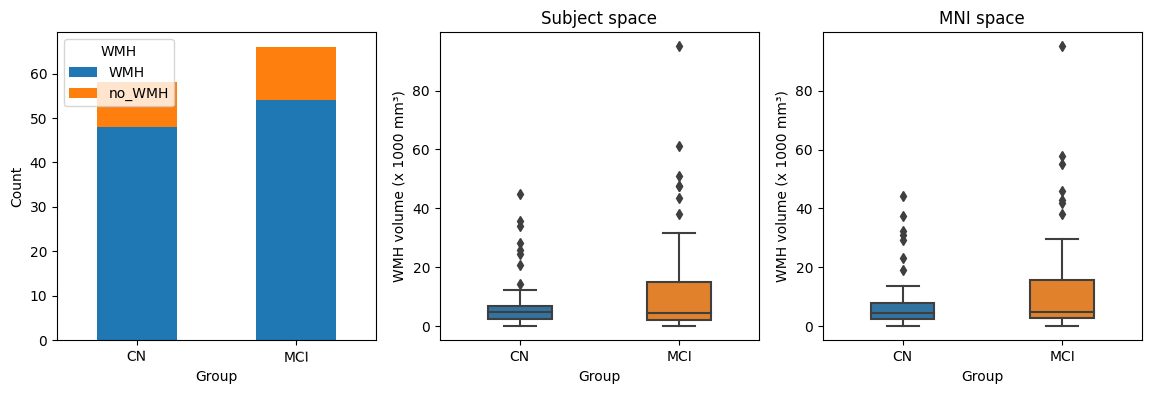

In [5]:
pts_df_M = pts_df[pts_df['Sex'] == "M"]
# Create contingency tables for wmh presence
ct_wmh_M = pd.crosstab(pts_df_M['WMH'], pts_df_M['Group_bin'])
c2_M, p2_M, dof2_M, expected2_M = ss.chi2_contingency(ct_wmh_M)

# Test if WMH volumes are normal or not 
normality_subj_M = ss.normaltest(pts_df_M["WMH_load_subj_space"])
normality_mni_M = ss.normaltest(pts_df_M["WMH_load_subj_space"])
# If normal use parametric tests, else use non-parametric
if normality_subj_M[1] < 0.05:
    print("Data is not normally distributed in subject space, you should use non-parametric tests\n")
else:
    print("Data is normally distributed in subject space, you should use parametric tests\n")

if normality_mni_M[1] < 0.05:
    print("Data is not normally distributed in MNI space, you should use non-parametric tests\n")
else:
    print("Data is normally distributed in MNI space, you should use parametric tests\n")

# Create figure
order_M = ['CN', 'MCI']
plt.figure(figsize = (14,4))
# First part is count of how many patients have/don't have WMH with our cutoff
axs1_M = plt.subplot(1, 3, 1)
f1_M = ct_wmh_M.T.plot(kind = "bar", stacked = True, rot = 1, ax = axs1_M)
plt.xlabel("Group")
plt.ylabel("Count")

# Second part is boxplot of WMH lesion load in subj space
axs2_M = plt.subplot(1, 3, 2)
# Divide by 1000 to make it shorter on the graph
wmh_less_zeros_M = pts_df_M['WMH_load_subj_space'] / 1000
f2_M = sns.boxplot(data=pts_df_M, x = "Group_bin", y = wmh_less_zeros_M, order = order, width = 0.4, ax = axs2_M);
# Add statistical annotation on graph
sa1_M = add_stat_annotation(f2, data=pts_df_M, x="Group_bin", y=wmh_less_zeros_M, order=order_M,
                    box_pairs=[("CN", "MCI")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=0);
# Also print the results
print(f"CN v.s. MCI in subject space: {sa1_M[1][0]}\n")
plt.xlabel("Group")
plt.ylabel("WMH volume (x 1000 mm\u00b3)")
plt.title("Subject space")

# Third part is boxplot of WMH lesion load in MNI space
axs3_M = plt.subplot(1, 3, 3)
wmh_less_zeros_mni_M = pts_df_M['WMH_load_mni_space'] / 1000
f3_M = sns.boxplot(data=pts_df_M, x = "Group_bin", y = wmh_less_zeros_mni_M, order = order, width = 0.4, ax = axs3_M);
# Add statistical annotation on graph
sa2_M = add_stat_annotation(f3, data=pts_df_M, x="Group_bin", y=wmh_less_zeros_mni_M, order=order,
                    box_pairs=[("CN", "MCI")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=0);
# Also print the results
print(f"CN v.s. MCI in MNI space: {sa2_M[1][0]}")
plt.xlabel("Group")
plt.ylabel("WMH volume (x 1000 mm\u00b3)")
plt.title("MNI space");

Data is not normally distributed in subject space, you should use non-parametric tests

Data is not normally distributed in MNI space, you should use non-parametric tests

CN v.s. MCI in subject space: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.684e-01 U_stat=3.015e+03

CN v.s. MCI in MNI space: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.314e-01 U_stat=2.987e+03


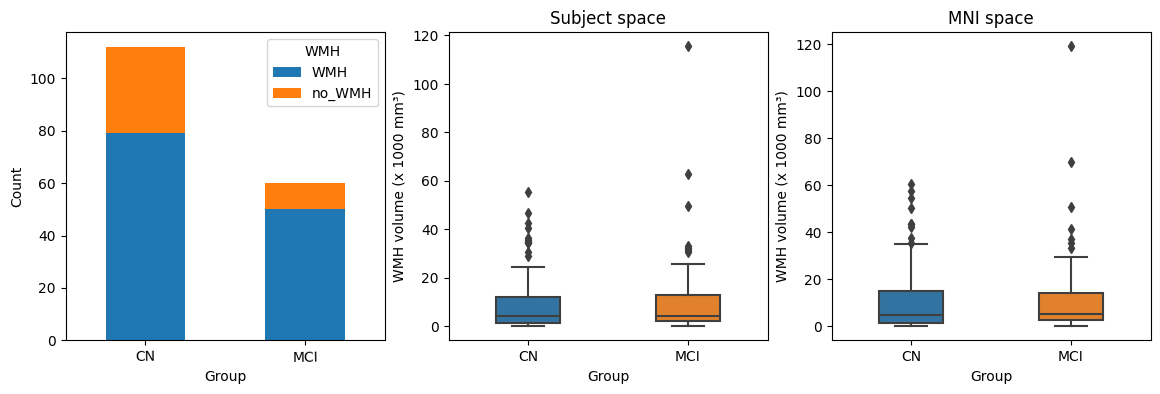

In [7]:
pts_df_F = pts_df[pts_df['Sex'] == "F"]
# Create contingency tables for wmh presence
ct_wmh_F = pd.crosstab(pts_df_F['WMH'], pts_df_F['Group_bin'])
c2_F, p2_F, dof2_F, expected2_F = ss.chi2_contingency(ct_wmh_F)

# Test if WMH volumes are normal or not 
normality_subj_F = ss.normaltest(pts_df_F["WMH_load_subj_space"])
normality_Fni_F = ss.normaltest(pts_df_F["WMH_load_subj_space"])
# If normal use parametric tests, else use non-parametric
if normality_subj_F[1] < 0.05:
    print("Data is not normally distributed in subject space, you should use non-parametric tests\n")
else:
    print("Data is normally distributed in subject space, you should use parametric tests\n")

if normality_Fni_F[1] < 0.05:
    print("Data is not normally distributed in MNI space, you should use non-parametric tests\n")
else:
    print("Data is normally distributed in MNI space, you should use parametric tests\n")

# Create figure
order_F = ['CN', 'MCI']
plt.figure(figsize = (14,4))
# First part is count of how many patients have/don't have WMH with our cutoff
axs1_F = plt.subplot(1, 3, 1)
f1_F = ct_wmh_F.T.plot(kind = "bar", stacked = True, rot = 1, ax = axs1_F)
plt.xlabel("Group")
plt.ylabel("Count")

# Second part is boxplot of WMH lesion load in subj space
axs2_F = plt.subplot(1, 3, 2)
# Divide by 1000 to make it shorter on the graph
wmh_less_zeros_F = pts_df_F['WMH_load_subj_space'] / 1000
f2_F = sns.boxplot(data=pts_df_F, x = "Group_bin", y = wmh_less_zeros_F, order = order, width = 0.4, ax = axs2_F);
# Add statistical annotation on graph
sa1_F = add_stat_annotation(f2, data=pts_df_F, x="Group_bin", y=wmh_less_zeros_F, order=order_F,
                    box_pairs=[("CN", "MCI")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=0);
# Also print the results
print(f"CN v.s. MCI in subject space: {sa1_F[1][0]}\n")
plt.xlabel("Group")
plt.ylabel("WMH volume (x 1000 mm\u00b3)")
plt.title("Subject space")

# Third part is boxplot of WMH lesion load in MNI space
axs3_F = plt.subplot(1, 3, 3)
wmh_less_zeros_Fni_F = pts_df_F['WMH_load_mni_space'] / 1000
f3_F = sns.boxplot(data=pts_df_F, x = "Group_bin", y = wmh_less_zeros_Fni_F, order = order, width = 0.4, ax = axs3_F);
# Add statistical annotation on graph
sa2_F = add_stat_annotation(f3, data=pts_df_F, x="Group_bin", y=wmh_less_zeros_Fni_F, order=order,
                    box_pairs=[("CN", "MCI")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=0);
# Also print the results
print(f"CN v.s. MCI in MNI space: {sa2_F[1][0]}")
plt.xlabel("Group")
plt.ylabel("WMH volume (x 1000 mm\u00b3)")
plt.title("MNI space");

There are no significant differences regarding WMH presence (yes/no) as characterized by the 25p threshold of CN subjects. Also, there are no statistically significant differences when considering the continuous distribution of WMH lesion load. The distributions of WMH in subject space and MNI space seem really similar. As expected, WMH volumes tend to increase with age...

<Axes: xlabel='Age', ylabel='WMH_load_subj_space'>

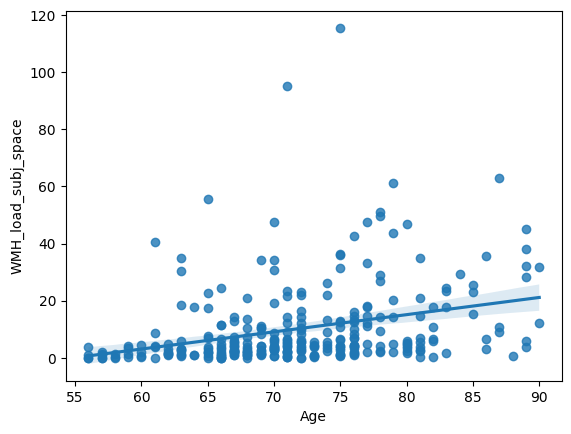

In [364]:
wmh_less_zeros = pts_df['WMH_load_subj_space'] / 1000
sns.regplot(pts_df, y = wmh_less_zeros, x = "Age")

Now, let's make a final summary table...

In [365]:
# Make final table
ct_sex['p-value'] = p1
ct_wmh['p-value'] = p2

p_age = stats[1][0].__dict__['pval']
median_age = age_summ['50%'].astype(str) + " (" + age_summ['25%'].astype(str) + "-" + age_summ['75%'].astype(str) + ")"
age_summ["Median (IQR)"] = median_age
ct_age = age_summ.T.iloc[-1:,:]
ct_age['p-value'] = p_age
table = pd.concat([ct_sex, ct_wmh, ct_age])
table['p-value'] = round(table['p-value'], 4)
print(table)

Group_bin                   CN               MCI  p-value
F                          112                60   0.0024
M                           58                66   0.0024
WMH                        127               104   0.1422
no_WMH                      43                22   0.1422
Median (IQR)  69.0 (66.0-75.0)  73.0 (69.0-78.0)   0.0002


# Analysis of ADNIMERGE & WMH

<div class="alert alert-block alert-info">
<b>Note:</b> This second part deals only with those subjects for whom we have ADNIMERGE data!!! Some (28) patients that we considered for the petTOAD study were from the screening visit of ADNI and they are not recorded on ADNIMERGE, so the following analyses exclude those patients!
</div>

Let's repeat the same analyses as we did before...

Median age for CN subjects = 70.0 (IQR = 66.0 - 76.0)
Median age for MCI subjects = 72.0 (IQR = 68.0 - 78.0)


Data is not normally distributed in subject space, you should use non-parametric tests

Data is not normally distributed in MNI space, you should use non-parametric tests

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CN v.s. MCI: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.559e-03 U_stat=7.040e+03
CN v.s. MCI in subject space: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.213e-01 U_stat=8.273e+03

CN v.s. MCI in MNI space: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.054e-01 U_stat=8.256e+03


Group_bin                   CN               MCI  p-value
F                          103                52   0.0008
M                           51                62   0.0008
WMH          

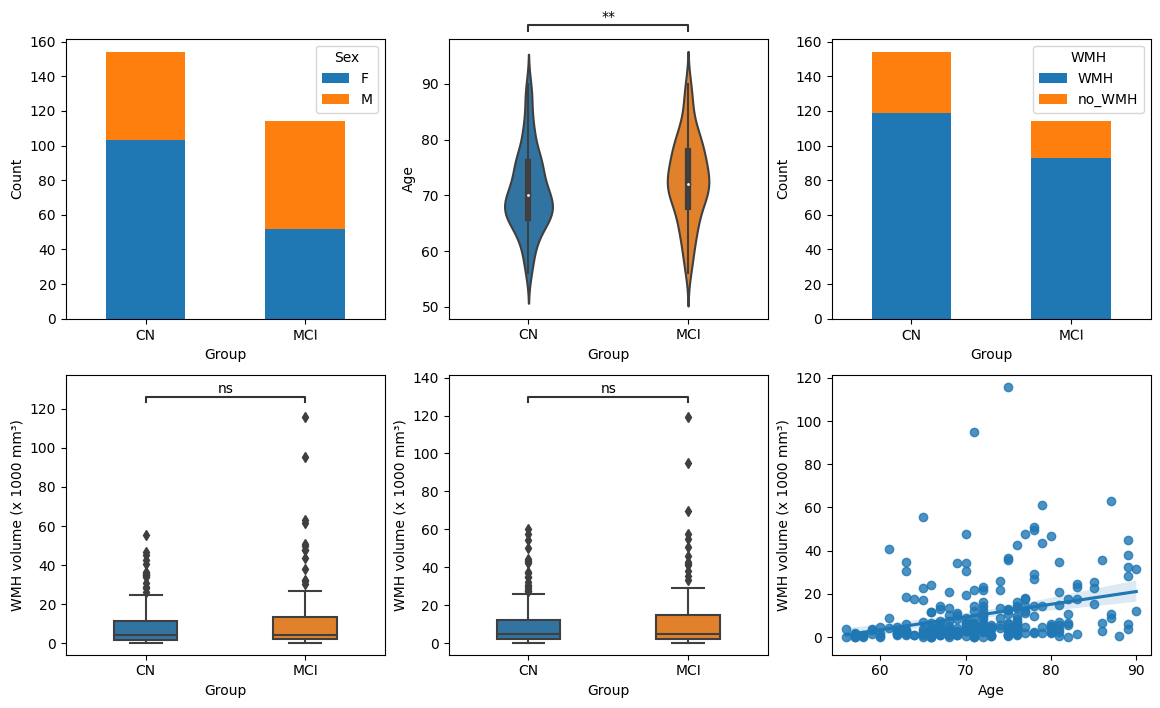

In [414]:
adnimerge = pd.read_csv(RES_DIR / "ADNIMERGE_petTOAD.csv")
adnimerge['WMH'] = np.where(adnimerge["Group_bin_subj"].str.contains("no_WMH"), "no_WMH", "WMH")
# Create contingency tables
ct_sex = pd.crosstab(adnimerge['Sex'], adnimerge['Group_bin'])
c1, p1, dof1, expected1 = ss.chi2_contingency(ct_sex)

# Get age summary stats
age_summ = adnimerge.groupby(["Group_bin"])['Age'].describe()
print(f"Median age for CN subjects = {age_summ['50%']['CN']} (IQR = {age_summ['25%']['CN']} - {age_summ['75%']['CN']})")
print(f"Median age for MCI subjects = {age_summ['50%']['MCI']} (IQR = {age_summ['25%']['MCI']} - {age_summ['75%']['MCI']})")

# Create contingency tables for wmh presence
ct_wmh = pd.crosstab(adnimerge['WMH'], adnimerge['Group_bin'])
c2, p2, dof2, expected2 = ss.chi2_contingency(ct_wmh)

# Test if WMH volumes are normal or not 
normality_subj = ss.normaltest(adnimerge["WMH_load_subj_space"])
normality_mni = ss.normaltest(adnimerge["WMH_load_subj_space"])
print("\n")
# If normal use parametric tests, else use non-parametric
if normality_subj[1] < 0.05:
    print("Data is not normally distributed in subject space, you should use non-parametric tests\n")
else:
    print("Data is normally distributed in subject space, you should use parametric tests\n")

if normality_mni[1] < 0.05:
    print("Data is not normally distributed in MNI space, you should use non-parametric tests\n")
else:
    print("Data is normally distributed in MNI space, you should use parametric tests\n")

order = ['CN', 'MCI']

# Create overall figure
fig, axs = plt.subplots(2, 3, figsize = (14,8))
# Set first graph
ct_sex.T.plot(kind = "bar", stacked = True, rot = 1, ylabel = "Num.", ax = axs[0,0])
axs[0,0].set_xlabel("Group")
axs[0,0].set_ylabel("Count")
# Set second graph
order = ['CN', 'MCI']
vp = sns.violinplot(adnimerge, x = "Group_bin", y = "Age", order = order, width = 0.3, ax = axs[0,1])
stats = add_stat_annotation(vp, data=adnimerge, x="Group_bin", y="Age",
                    box_pairs=[("CN", "MCI")],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=3);
axs[0,1].set_xlabel("Group")
axs[0,1].set_ylabel("Age")

# First part is count of how many patients have/don't have WMH with our cutoff
f1 = ct_wmh.T.plot(kind = "bar", stacked = True, rot = 1, ax = axs[0,2])
axs[0,2].set_xlabel("Group")
axs[0,2].set_ylabel("Count")

# Divide by 1000 to make it shorter on the graph
wmh_less_zeros = adnimerge['WMH_load_subj_space'] / 1000
f2 = sns.boxplot(data=adnimerge, x = "Group_bin", y = wmh_less_zeros, order = order, width = 0.4, ax = axs[1,0]);
# Add statistical annotation on graph
sa1 = add_stat_annotation(f2, data=adnimerge, x="Group_bin", y=wmh_less_zeros, order=order,
                    box_pairs=[("CN", "MCI")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=0);

axs[1,0].set_xlabel("Group")
axs[1,0].set_ylabel("WMH volume (x 1000 mm\u00b3)")
# Third part is boxplot of WMH lesion load in MNI space
wmh_less_zeros_mni = adnimerge['WMH_load_mni_space'] / 1000
f3 = sns.boxplot(data=adnimerge, x = "Group_bin", y = wmh_less_zeros_mni, order = order, width = 0.4, ax = axs[1,1]);
# Add statistical annotation on graph
sa2 = add_stat_annotation(f3, data=adnimerge, x="Group_bin", y=wmh_less_zeros_mni, order=order,
                    box_pairs=[("CN", "MCI")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=0);

axs[1,1].set_xlabel("Group")
axs[1,1].set_ylabel("WMH volume (x 1000 mm\u00b3)")

sns.regplot(adnimerge, y = wmh_less_zeros, x = "Age", ax = axs[1,2])
axs[1,2].set_xlabel("Age")
axs[1,2].set_ylabel("WMH volume (x 1000 mm\u00b3)")
# Also print the results
print(f"CN v.s. MCI in subject space: {sa1[1][0]}\n")
print(f"CN v.s. MCI in MNI space: {sa2[1][0]}")
# Make final table
ct_sex['p-value'] = p1
ct_wmh['p-value'] = p2

p_age = stats[1][0].__dict__['pval']
median_age = age_summ['50%'].astype(str) + " (" + age_summ['25%'].astype(str) + "-" + age_summ['75%'].astype(str) + ")"
age_summ["Median (IQR)"] = median_age
ct_age = age_summ.T.iloc[-1:,:]
ct_age['p-value'] = p_age
table = pd.concat([ct_sex, ct_wmh, ct_age])
table['p-value'] = round(table['p-value'], 4)
print("\n")
print(table)


Check some potential interesting differences amongst groups

<Axes: xlabel='Hippocampus', ylabel='WMH_load_subj_space'>

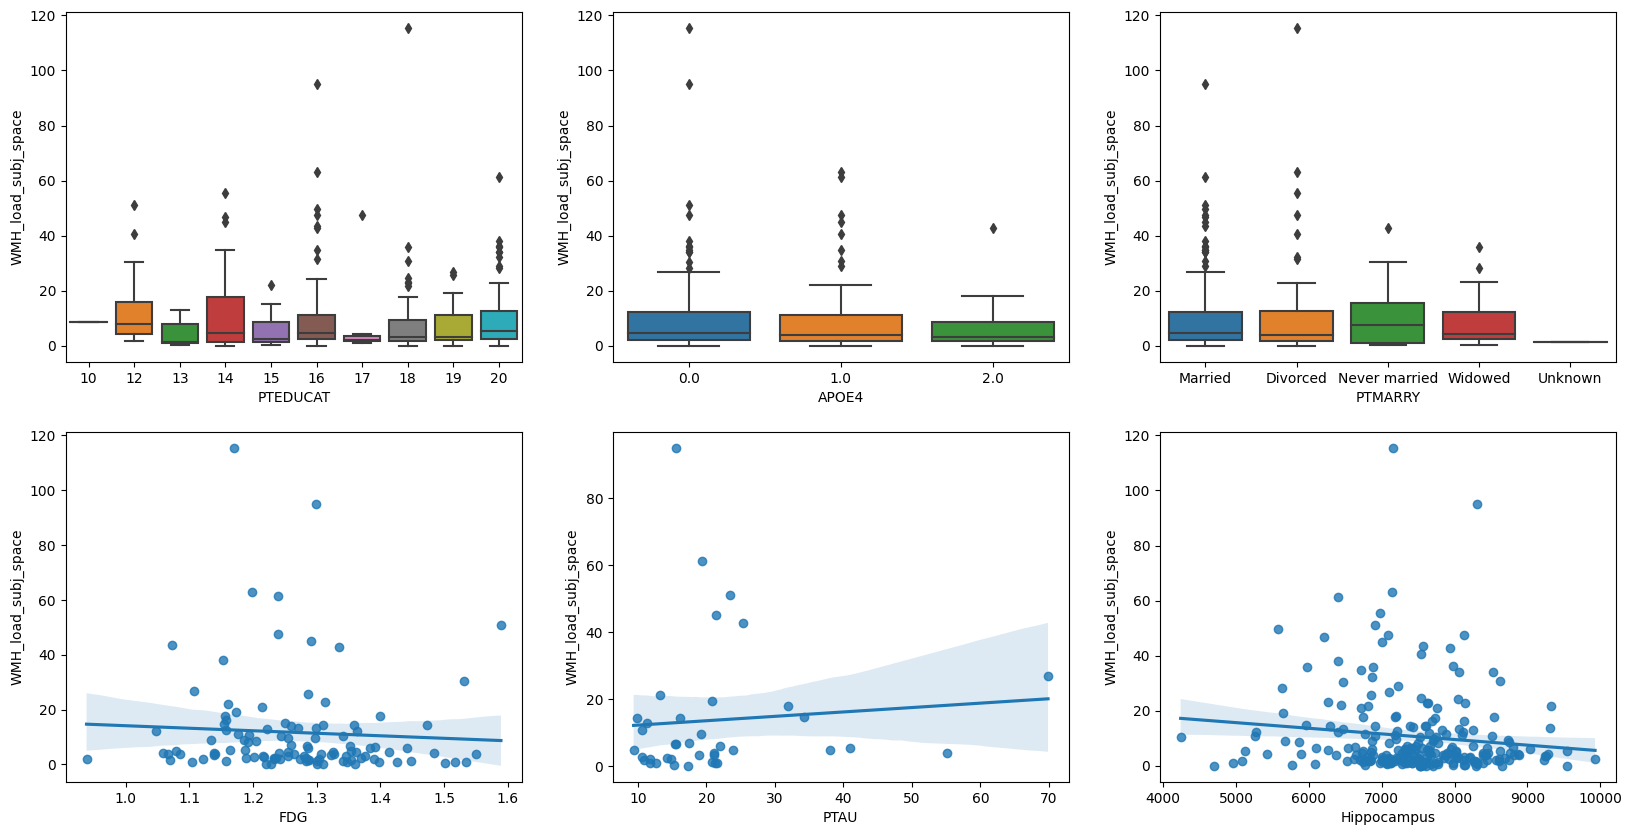

In [437]:
fig, axs = plt.subplots(2,3, figsize = (20,10))
sns.boxplot(adnimerge, x = "PTEDUCAT", y = wmh_less_zeros, ax = axs[0,0])
sns.boxplot(adnimerge, x = "APOE4", y = wmh_less_zeros, ax = axs[0,1])
sns.boxplot(adnimerge, x = "PTMARRY", y = wmh_less_zeros, ax = axs[0,2])
sns.regplot(adnimerge, x = "FDG", y = wmh_less_zeros, ax = axs[1,0])
sns.regplot(adnimerge, x = "PTAU", y = wmh_less_zeros, ax = axs[1,1])
sns.regplot(adnimerge, x = "Hippocampus", y = wmh_less_zeros, ax = axs[1,2])